# Bagging与随机森林

<font size =3>Bagging是并行式集成学习方法最典型的代表框架。其核心概念在于自助采样（Bootstrap Sampling），给定包含m个样本的数据集，有放回的随机抽取一个样本放入采样集中，经过m次采样，可得到一个和原始数据集一样大小的采样集。我们可以采样得到T个包含m个样本的采样集，然后基于每个采样集训练出一个基学习器，最后将这些基学习器进行组合。这便是Bagging的主要思想。Bagging与Boosting图示如下：

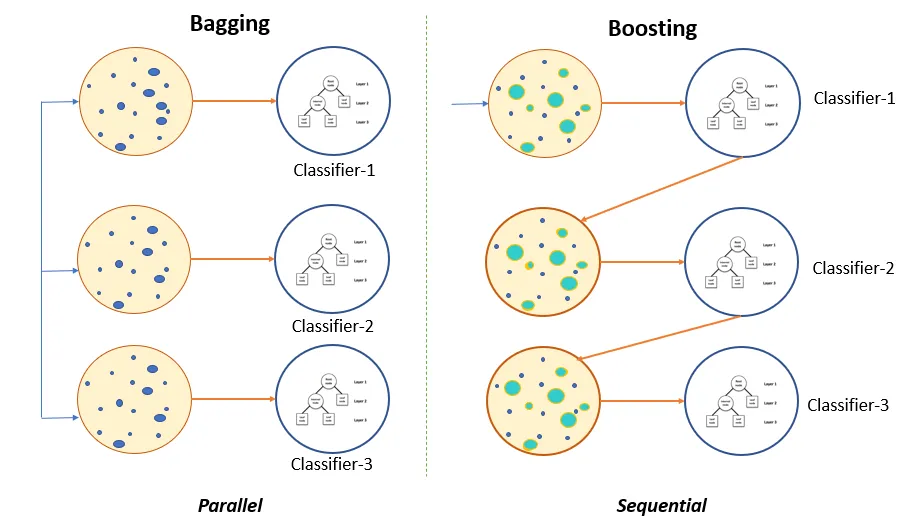

两个随机性。具体如下：

- 假设有M个样本，有放回的随机选择M个样本（每次随机选择一个放回后继续选）。

- 假设样本有N个特征，在决策时的每个节点需要分裂时，随机地从这N个特征中选取n个特征，满足n<<N，从这n个特征中选择特征进行节点分裂。

- 基于抽样的M个样本n个特征按照节点分裂的方式构建决策树。

- 按照1~3步构建大量决策树组成随机森林，然后将每棵树的结果进行综合（分类使用投票法，回归可使用均值法）。

In [3]:
class DecisionTree(object):
    """Super class of RegressionTree and ClassificationTree.
    Parameters:
    -----------
    min_samples_split: int
        The minimum number of samples needed to make a split when building a tree.
    min_impurity: float
        The minimum impurity required to split the tree further.
    max_depth: int
        The maximum depth of a tree.
    loss: function
        Loss function that is used for Gradient Boosting models to calculate impurity.
    """

    def __init__(self, min_samples_split=2, min_impurity=1e-7,
                 max_depth=float("inf"), loss=None):
        self.root = None  # Root node in dec. tree
        # Minimum n of samples to justify split
        self.min_samples_split = min_samples_split
        # The minimum impurity to justify split
        self.min_impurity = min_impurity
        # The maximum depth to grow the tree to
        self.max_depth = max_depth
        # Function to calculate impurity (classif.=>info gain, regr=>variance reduct.)
        # 切割树的方法，gini，方差等
        self._impurity_calculation = None
        # Function to determine prediction of y at leaf
        # 树节点取值的方法，分类树：选取出现最多次数的值，回归树：取所有值的平均值
        self._leaf_value_calculation = None
        # If y is one-hot encoded (multi-dim) or not (one-dim)
        self.one_dim = None
        # If Gradient Boost
        self.loss = loss

    def fit(self, X, y, loss=None):
        """ Build decision tree """
        self.one_dim = len(np.shape(y)) == 1
        self.root = self._build_tree(X, y)
        self.loss = None

    def _build_tree(self, X, y, current_depth=0):
        """ Recursive method which builds out the decision tree and splits X and respective y
        on the feature of X which (based on impurity) best separates the data"""
        largest_impurity = 0
        best_criteria = None  # Feature index and threshold
        best_sets = None  # Subsets of the data

        # Check if expansion of y is needed
        if len(np.shape(y)) == 1:
            y = np.expand_dims(y, axis=1)

        # Add y as last column of X
        Xy = np.concatenate((X, y), axis=1)

        n_samples, n_features = np.shape(X)

        if n_samples >= self.min_samples_split and current_depth <= self.max_depth:
            # Calculate the impurity for each feature
            for feature_i in range(n_features):
                # All values of feature_i
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)

                # Iterate through all unique values of feature column i and
                # calculate the impurity
                for threshold in unique_values:
                    # Divide X and y depending on if the feature value of X at index feature_i
                    # meets the threshold
                    Xy1, Xy2 = divide_on_feature(Xy, feature_i, threshold)

                    if len(Xy1) > 0 and len(Xy2) > 0:
                        # Select the y-values of the two sets
                        y1 = Xy1[:, n_features:]
                        y2 = Xy2[:, n_features:]

                        # Calculate impurity
                        impurity = self._impurity_calculation(y, y1, y2)

                        # If this threshold resulted in a higher information gain than previously
                        # recorded save the threshold value and the feature
                        # index
                        if impurity > largest_impurity:
                            largest_impurity = impurity
                            best_criteria = {"feature_i": feature_i, "threshold": threshold}
                            best_sets = {
                                "leftX": Xy1[:, :n_features],  # X of left subtree
                                "lefty": Xy1[:, n_features:],  # y of left subtree
                                "rightX": Xy2[:, :n_features],  # X of right subtree
                                "righty": Xy2[:, n_features:]  # y of right subtree
                            }

        if largest_impurity > self.min_impurity:
            # Build subtrees for the right and left branches
            true_branch = self._build_tree(best_sets["leftX"], best_sets["lefty"], current_depth + 1)
            false_branch = self._build_tree(best_sets["rightX"], best_sets["righty"], current_depth + 1)
            return DecisionNode(feature_i=best_criteria["feature_i"], threshold=best_criteria[
                "threshold"], true_branch=true_branch, false_branch=false_branch)

        # We're at leaf => determine value
        leaf_value = self._leaf_value_calculation(y)
        return DecisionNode(value=leaf_value)

    def predict_value(self, x, tree=None):
        """ Do a recursive search down the tree and make a prediction of the data sample by the
            value of the leaf that we end up at """

        if tree is None:
            tree = self.root

        # If we have a value (i.e we're at a leaf) => return value as the prediction
        if tree.value is not None:
            return tree.value

        # Choose the feature that we will test
        feature_value = x[tree.feature_i]

        # Determine if we will follow left or right branch
        branch = tree.false_branch
        if isinstance(feature_value, int) or isinstance(feature_value, float):
            if feature_value >= tree.threshold:
                branch = tree.true_branch
        elif feature_value == tree.threshold:
            branch = tree.true_branch

        # Test subtree
        return self.predict_value(x, branch)

    def predict(self, X):
        """ Classify samples one by one and return the set of labels """
        y_pred = []
        for x in X:
            y_pred.append(self.predict_value(x))
        return y_pred

    def print_tree(self, tree=None, indent=" "):
        """ Recursively print the decision tree """
        if not tree:
            tree = self.root

        # If we're at leaf => print the label
        if tree.value is not None:
            print(tree.value)
        # Go deeper down the tree
        else:
            # Print test
            print("%s:%s? " % (tree.feature_i, tree.threshold))
            # Print the true scenario
            print("%sT->" % (indent), end="")
            self.print_tree(tree.true_branch, indent + indent)
            # Print the false scenario
            print("%sF->" % (indent), end="")
            self.print_tree(tree.false_branch, indent + indent)

In [4]:
class ClassificationTree(DecisionTree):
    def _calculate_information_gain(self, y, y1, y2):
        # Calculate information gain
        p = len(y1) / len(y)
        entropy = calculate_entropy(y)
        info_gain = entropy - p * \
                              calculate_entropy(y1) - (1 - p) * \
                                                      calculate_entropy(y2)
        # print("info_gain",info_gain)
        return info_gain

    def _majority_vote(self, y):
        most_common = None
        max_count = 0
        for label in np.unique(y):
            # Count number of occurences of samples with label
            count = len(y[y == label])
            if count > max_count:
                most_common = label
                max_count = count
        # print("most_common :",most_common)
        return most_common

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_information_gain
        self._leaf_value_calculation = self._majority_vote
        super(ClassificationTree, self).fit(X, y)

In [5]:
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
# 树的棵数
n_estimators = 10
# 列抽样最大特征数
max_features = 15
# 生成模拟二分类数据集
X, y = make_classification(n_samples=1000, n_features=20, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(700, 20) (700,) (300, 20) (300,)


In [6]:

# 自助抽样选择训练数据子集
def bootstrap_sampling(X, y):
    X_y = np.concatenate([X, y.reshape(-1,1)], axis=1)
    np.random.shuffle(X_y)
    n_samples = X.shape[0]
    sampling_subsets = []

    for _ in range(n_estimators):
        # 第一个随机性，行抽样
        idx1 = np.random.choice(n_samples, n_samples, replace=True)
        bootstrap_Xy = X_y[idx1, :]
        bootstrap_X = bootstrap_Xy[:, :-1]
        bootstrap_y = bootstrap_Xy[:, -1]
        sampling_subsets.append([bootstrap_X, bootstrap_y])
    return sampling_subsets

In [7]:

trees = []
# 基于决策树构建森林
for _ in range(n_estimators):
    tree = ClassificationTree(min_samples_split=2, min_impurity=0,
                              max_depth=3)
    trees.append(tree)

In [8]:

# 随机森林训练
def fit(X, y):
    # 对森林中每棵树训练一个双随机抽样子集
    n_features = X.shape[1]
    sub_sets = bootstrap_sampling(X, y)
    for i in range(n_estimators):
        sub_X, sub_y = sub_sets[i]
        # 第二个随机性，列抽样
        idx2 = np.random.choice(n_features, max_features, replace=True)
        sub_X = sub_X[:, idx2]
        trees[i].fit(sub_X, sub_y)
        trees[i].feature_indices = idx2
        print('The {}th tree is trained done...'.format(i+1))